In [ ]:
!git clone https://github.com/loadthecode0/causal-speech-enhancement

Cloning into 'causal-speech-enhancement'...
remote: Enumerating objects: 751, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 751 (delta 123), reused 84 (delta 80), pack-reused 595 (from 3)
Receiving objects: 100% (751/751), 1.38 GiB | 29.88 MiB/s, done.
Resolving deltas: 100% (446/446), done.
Updating files: 100% (46/46), done.


In [ ]:
import os
os.chdir('causal-speech-enhancement')

In [ ]:
# importing data


In [ ]:
#Setting up dataset
import os
import glob
import torch
import torchaudio
from torch.utils.data import Dataset

class EARSWHAMAudioDataset(Dataset):
    def __init__(self, base_dir = "../datasets_final/EARS-WHAM16kHz", dataset="train", transform=None, seg_length = 16000):
        """
        Args:
            base_dir (str): Path to the base directory containing train, valid, and test subdirectories.
            dataset (str): Dataset split to use ("train", "valid", "test").
            transform (callable, optional): Optional transform to apply to the audio data.
        """
        assert dataset in ["train", "valid", "test"], "Invalid dataset split. Choose from 'train', 'valid', or 'test'."
        self.transform = transform
        self.seg_length = seg_length

         # Set directories for clean and noisy files based on the dataset split
        self.clean_dir = os.path.join(base_dir, dataset, "clean")
        self.noisy_dir = os.path.join(base_dir, dataset, "noisy")
        # Gather and sort file names to ensure pairing
        self.clean_files = sorted(glob.glob(os.path.join(self.clean_dir, "**/*.wav"), recursive=True))
        self.noisy_files = sorted(glob.glob(os.path.join(self.noisy_dir, "**/*.wav"), recursive=True))

        # Ensure clean and noisy file lists match
        assert len(self.clean_files) == len(self.noisy_files), \
            f"Mismatch in the number of clean and noisy files for {dataset} dataset."


    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        clean_waveform, _ = torchaudio.load(self.clean_files[idx])
        noisy_waveform, _ = torchaudio.load(self.noisy_files[idx])

        audio_length = clean_waveform.size(1)

        #We find a random starting point for the segment
        if audio_length > self.seg_length:
            start = torch.randint(0, audio_length - self.seg_length, (1, )).item()
            clean_waveform = clean_waveform[:, start: start + self.seg_length]
            noisy_waveform = noisy_waveform[:, start:start + self.seg_length]
        else:
            pad_length = self.seg_length - audio_length
            clean_waveform = torch.nn.functional.pad(clean_waveform, (0, pad_length))
            noisy_waveform = torch.nn.functional.pad(noisy_waveform, (0, pad_length))


        # Apply optional transformation
        if self.transform:
            clean_waveform = self.transform(clean_waveform)
            noisy_waveform = self.transform(noisy_waveform)

        return clean_waveform, noisy_waveform  # Tuple of clean and noisy waveforms

'''
DataLoader Usage:
# Create dataset instances for each split
train_dataset = AudioDataset(base_dir="EARS-WHAM-16.0kHz", dataset="train", seg_length=16000)
valid_dataset = AudioDataset(base_dir="EARS-WHAM-16.0kHz", dataset="valid", seg_length=16000)
test_dataset = AudioDataset(base_dir="EARS-WHAM-16.0kHz", dataset="test", seg_length=16000)

# Define DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

# Example usage: Iterate through the training DataLoader
for batch_idx, (clean_batch, noisy_batch) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}")
    print(f"Clean Shape: {clean_batch.shape}, Noisy Shape: {noisy_batch.shape}")

For Training:
for epoch in range(num_epochs):
    for clean_batch, noisy_batch in train_loader:
        # Move to GPU if available
        clean_batch = clean_batch.to(device)
        noisy_batch = noisy_batch.to(device)

        # Forward pass
        output = model(noisy_batch)

        # Loss calculation and optimization
        loss = loss_function(output, clean_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1} completed.")
'''

'\nDataLoader Usage:\n# Create dataset instances for each split\ntrain_dataset = AudioDataset(base_dir="EARS-WHAM-16.0kHz", dataset="train", seg_length=16000)\nvalid_dataset = AudioDataset(base_dir="EARS-WHAM-16.0kHz", dataset="valid", seg_length=16000)\ntest_dataset = AudioDataset(base_dir="EARS-WHAM-16.0kHz", dataset="test", seg_length=16000)\n\n# Define DataLoader instances\ntrain_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)\nvalid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)\ntest_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)\n\n# Example usage: Iterate through the training DataLoader\nfor batch_idx, (clean_batch, noisy_batch) in enumerate(train_loader):\n    print(f"Batch {batch_idx + 1}")\n    print(f"Clean Shape: {clean_batch.shape}, Noisy Shape: {noisy_batch.shape}")\n\nFor Training:\nfor epoch in range(num_epochs):\n    for clean

In [ ]:
#dataloader
from data.dataset import EARSWHAMAudioDataset # custom class earlier
from torch.utils.data import DataLoader

class EARSWHAMDataLoader:
    def __init__(self, base_dir="../datasets_final/EARS-WHAM16kHz", seg_length=16000, batch_size=8, num_workers=4, transform=None):
        self.base_dir = base_dir
        self.seg_length = seg_length
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform

    def get_loader(self, split, shuffle=True):
        dataset = EARSWHAMAudioDataset(base_dir=self.base_dir, dataset=split, transform=self.transform, seg_length=self.seg_length)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=(shuffle if split == "train" else False),
                            num_workers=self.num_workers, pin_memory=True)
        return loader

'''
# Usage
data_loader = EARSWHAMDataLoader(batch_size=8, seg_length=16000, num_workers=4)
train_loader = data_loader.get_loader("train")
valid_loader = data_loader.get_loader("valid", shuffle=False)
test_loader = data_loader.get_loader("test", shuffle=False)
'''

'\n# Usage\ndata_loader = EARSWHAMDataLoader(batch_size=8, seg_length=16000, num_workers=4)\ntrain_loader = data_loader.get_loader("train")\nvalid_loader = data_loader.get_loader("valid", shuffle=False)\ntest_loader = data_loader.get_loader("test", shuffle=False)\n'

In [ ]:
#ConvTasNet Model
"""This file implements both the non-causal and causal versions of Conv-TasNet.

The implementation is based on the paper:
"Conv-TasNet: Surpassing Ideal Time–Frequency Magnitude Masking for Speech Separation"
by Yi Luo and Nima Mesgarani.

The code includes building blocks of Conv-TasNet and a wrapper to instantiate
either the causal or non-causal version based on user preference.
"""

from typing import Optional, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F

class CausalConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, groups=1):
        super(CausalConv1D, self).__init__()
        self.left_padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            dilation=dilation,
            groups=groups,
        )

    def forward(self, x):
        x = F.pad(x, (self.left_padding, 0))
        return self.conv(x)

class ConvBlock(torch.nn.Module):
    """Non-Causal 1D Convolutional block.

    This block uses symmetric padding, making it non-causal.

    Args:
        io_channels (int): Number of input/output channels, <B, Sc>.
        hidden_channels (int): Number of channels in the internal layers, <H>.
        kernel_size (int): Convolution kernel size of the middle layer, <P>.
        padding (int): Symmetric padding value for convolution.
        dilation (int, optional): Dilation value for convolution.
        no_residual (bool, optional): Disable residual output.
    """
    def __init__(self, io_channels: int, hidden_channels: int, kernel_size: int,
                 dilation: int = 1, no_residual: bool = False):
        super().__init__()
        self.no_residual = no_residual
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv1d(io_channels, hidden_channels, kernel_size=1),
            torch.nn.PReLU(),
            torch.nn.GroupNorm(1, hidden_channels, eps=1e-8),
            torch.nn.Conv1d(
                hidden_channels,
                hidden_channels,
                kernel_size=kernel_size,
                padding= (dilation * (kernel_size - 1) // 2),
                dilation=dilation,
                groups=hidden_channels,
            ),
            torch.nn.PReLU(),
            torch.nn.GroupNorm(1, hidden_channels, eps=1e-8),
        )
        self.res_out = (
            None if no_residual else torch.nn.Conv1d(hidden_channels, io_channels, kernel_size=1)
        )
        self.skip_out = torch.nn.Conv1d(hidden_channels, io_channels, kernel_size=1)

    def forward(self, input: torch.Tensor) -> Tuple[Optional[torch.Tensor], torch.Tensor]:
        feature = self.conv_layers(input)
        residual = self.res_out(feature) if not self.no_residual else None
        skip_out = self.skip_out(feature)
        return residual, skip_out


class CausalConvBlock(torch.nn.Module):
    """Causal 1D Convolutional block.

    This block uses left-padding to ensure that future frames are not accessed.

    Args:
        io_channels (int): Number of input/output channels, <B, Sc>.
        hidden_channels (int): Number of channels in the internal layers, <H>.
        kernel_size (int): Convolution kernel size of the middle layer, <P>.
        dilation (int, optional): Dilation value for convolution.
        no_residual (bool, optional): Disable residual output.
    """
    def __init__(self, io_channels: int, hidden_channels: int, kernel_size: int,
                 dilation: int = 1, no_residual: bool = False):
        super().__init__()
        self.left_padding = (kernel_size - 1) * dilation
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv1d(io_channels, hidden_channels, kernel_size=1),
            torch.nn.PReLU(),
            CausalConv1D(
                hidden_channels,
                hidden_channels,
                kernel_size=kernel_size,
                dilation=dilation,
                groups=hidden_channels,
            ),
            torch.nn.PReLU(),
        )
        self.res_out = (
            None if no_residual else torch.nn.Conv1d(hidden_channels, io_channels, kernel_size=1)
        )
        self.skip_out = torch.nn.Conv1d(hidden_channels, io_channels, kernel_size=1)

    def forward(self, input: torch.Tensor) -> Tuple[Optional[torch.Tensor], torch.Tensor]:
        feature = self.conv_layers(input)
        residual = self.res_out(feature) if self.res_out else None
        skip_out = self.skip_out(feature)
        return residual, skip_out


class MaskGenerator(torch.nn.Module):
    """TCN-based Mask Generator for both causal and non-causal versions.

    Args:
        causal (bool): Use causal convolutions if True, otherwise non-causal.
        Other arguments match the original Conv-TasNet implementation.
    """
    def __init__(self, input_dim: int, num_sources: int, kernel_size: int,
                 num_feats: int, num_hidden: int, num_layers: int, num_stacks: int,
                 msk_activate: str, causal: bool = False):
        super().__init__()
        self.input_dim = input_dim
        self.num_sources = num_sources
        self.input_norm = torch.nn.GroupNorm(1, input_dim, eps=1e-8)
        self.input_conv = torch.nn.Conv1d(input_dim, num_feats, kernel_size=1)

        self.receptive_field = 0
        self.conv_layers = torch.nn.ModuleList([])
        ConvBlockType = CausalConvBlock if causal else ConvBlock
        for s in range(num_stacks):
            for l in range(num_layers):
                dilation = 2**l
                self.conv_layers.append(
                    ConvBlockType(
                        io_channels=num_feats,
                        hidden_channels=num_hidden,
                        kernel_size=kernel_size,
                        dilation=dilation,
                        no_residual=(l == num_layers - 1 and s == num_stacks - 1),
                    )
                )
                self.receptive_field += kernel_size if s == 0 and l == 0 else (kernel_size - 1) * dilation
        self.output_prelu = torch.nn.PReLU()
        self.output_conv = torch.nn.Conv1d(num_feats, input_dim * num_sources, kernel_size=1)
        self.mask_activate = torch.nn.Sigmoid() if msk_activate == "sigmoid" else torch.nn.ReLU()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        batch_size = input.shape[0]
        feats = self.input_norm(input)
        feats = self.input_conv(feats)
        output = 0.0
        for layer in self.conv_layers:
            residual, skip = layer(feats)
            if residual is not None:
                feats = feats + residual
            output = output + skip
        output = self.output_prelu(output)
        output = self.output_conv(output)
        output = self.mask_activate(output)
        return output.view(batch_size, self.num_sources, self.input_dim, -1)


class ConvTasNet(torch.nn.Module):
    """Conv-TasNet implementation for both causal and non-causal settings.

    Args:
        causal (bool): Use causal convolutions if True, otherwise non-causal.
        Other arguments match the original Conv-TasNet implementation.
    """
    def __init__(self, num_sources: int = 2, enc_kernel_size: int = 16,
                 enc_num_feats: int = 512, msk_kernel_size: int = 3,
                 msk_num_feats: int = 128, msk_num_hidden_feats: int = 512,
                 msk_num_layers: int = 8, msk_num_stacks: int = 3,
                 msk_activate: str = "sigmoid", causal: bool = False):
        super().__init__()
        self.encoder = torch.nn.Conv1d(
            1, enc_num_feats, kernel_size=enc_kernel_size,
            stride=enc_kernel_size // 2, padding=enc_kernel_size // 2, bias=False,
        )
        self.mask_generator = MaskGenerator(
            input_dim=enc_num_feats,
            num_sources=num_sources,
            kernel_size=msk_kernel_size,
            num_feats=msk_num_feats,
            num_hidden=msk_num_hidden_feats,
            num_layers=msk_num_layers,
            num_stacks=msk_num_stacks,
            msk_activate=msk_activate,
            causal=causal,
        )
        self.decoder = torch.nn.ConvTranspose1d(
            enc_num_feats, 1, kernel_size=enc_kernel_size,
            stride=enc_kernel_size // 2, padding=enc_kernel_size // 2, bias=False,
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        padded, num_pads = self._align_num_frames_with_strides(input)
        feats = self.encoder(padded)
        masked = self.mask_generator(feats) * feats.unsqueeze(1)
        output = self.decoder(masked.view(-1, feats.size(1), feats.size(2)))
        return output.view(input.size(0), -1, input.size(2))

    def _align_num_frames_with_strides(self, input: torch.Tensor) -> Tuple[torch.Tensor, int]:
        num_frames = input.size(-1)
        stride = self.encoder.stride[0]
        pad = (stride - (num_frames % stride)) % stride
        return torch.nn.functional.pad(input, (0, pad)), pad


def build_conv_tasnet(causal: bool = False, **kwargs) -> ConvTasNet:
    """Wrapper to instantiate either causal or non-causal Conv-TasNet."""
    return ConvTasNet(causal=causal, **kwargs)

'''
Usage
Instantiate Non-Causal Model:
model = build_conv_tasnet(causal=False, num_sources=2)

Instantiate Causal Model:
model = build_conv_tasnet(causal=True, num_sources=2)
'''

'\nUsage\nInstantiate Non-Causal Model:\nmodel = build_conv_tasnet(causal=False, num_sources=2)\n\nInstantiate Causal Model:\nmodel = build_conv_tasnet(causal=True, num_sources=2)\n'

# **Results**
After much delegation, thought and training various combinations of architectural features we conducted a line of training and testing that gave us the following results. Below, are the training curves obtained and the sample testing code.

# Training
**Causal Standalone Training with Spectral Initialization:**
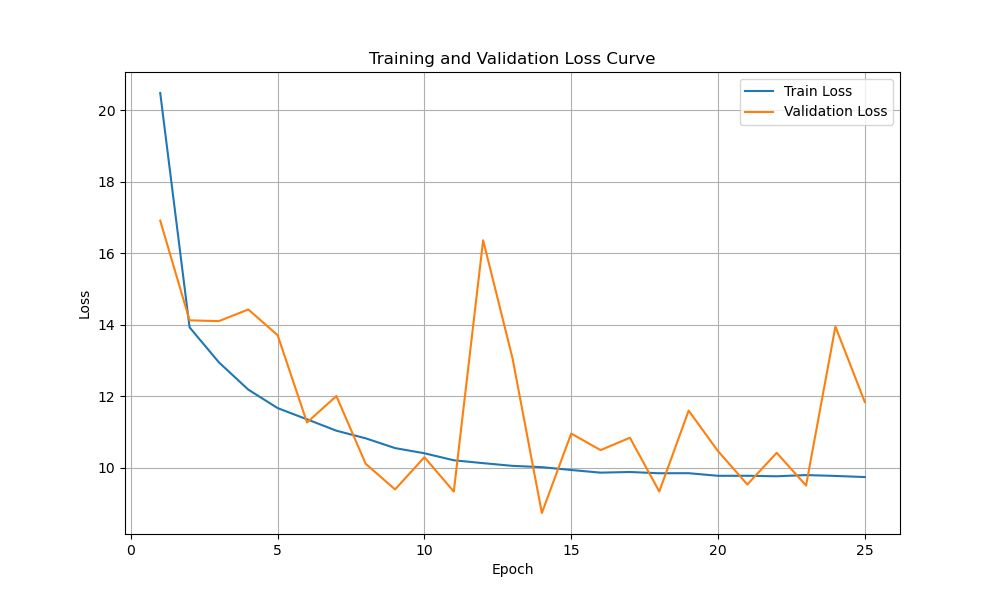
**Causal Standalone Training with Random Initialization:**
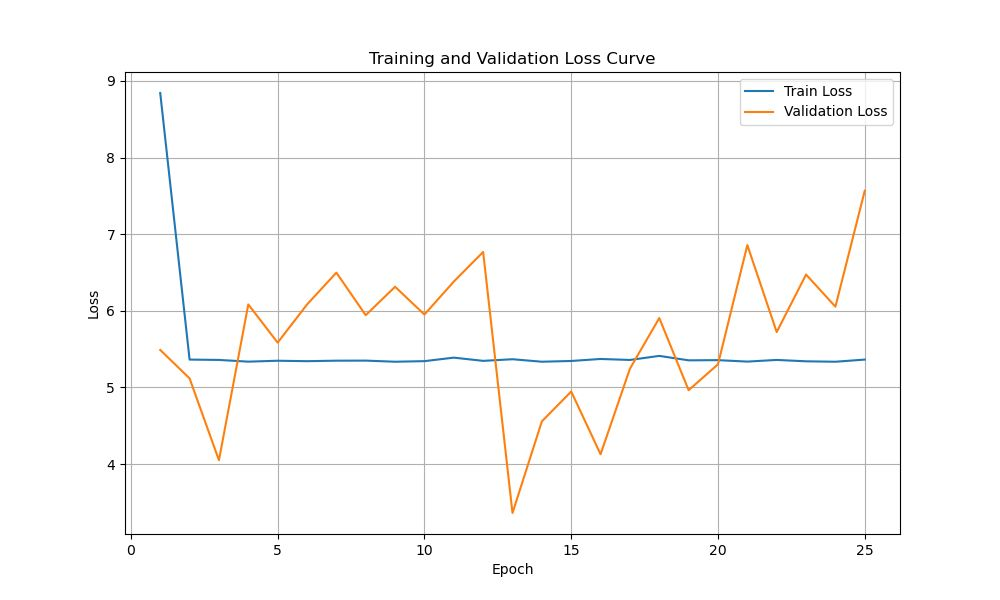
**Non-causal Standalone Training with Spectral Initialization:**
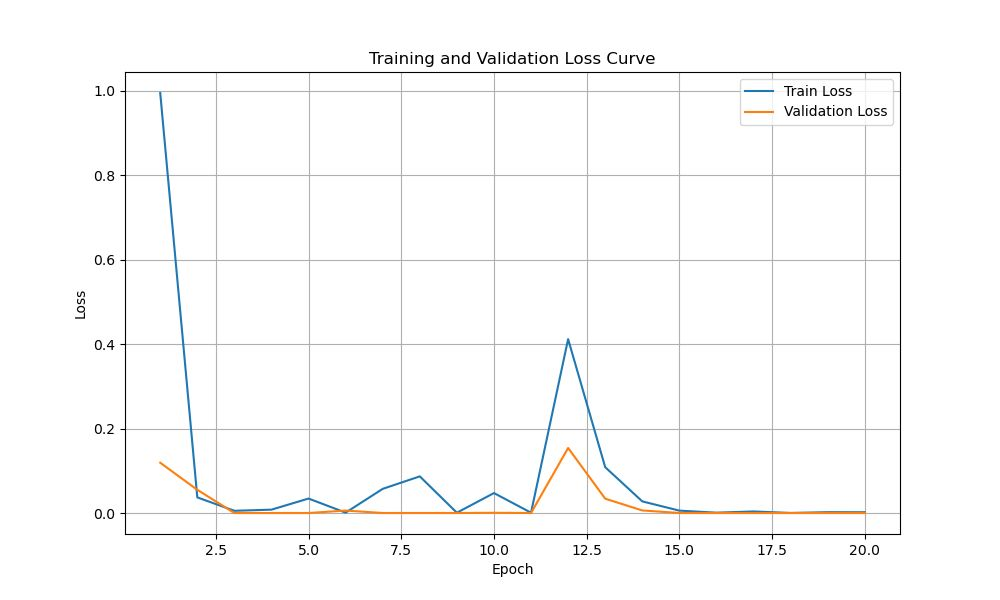
**Non-causal Standalone Training with Random Initialization:**
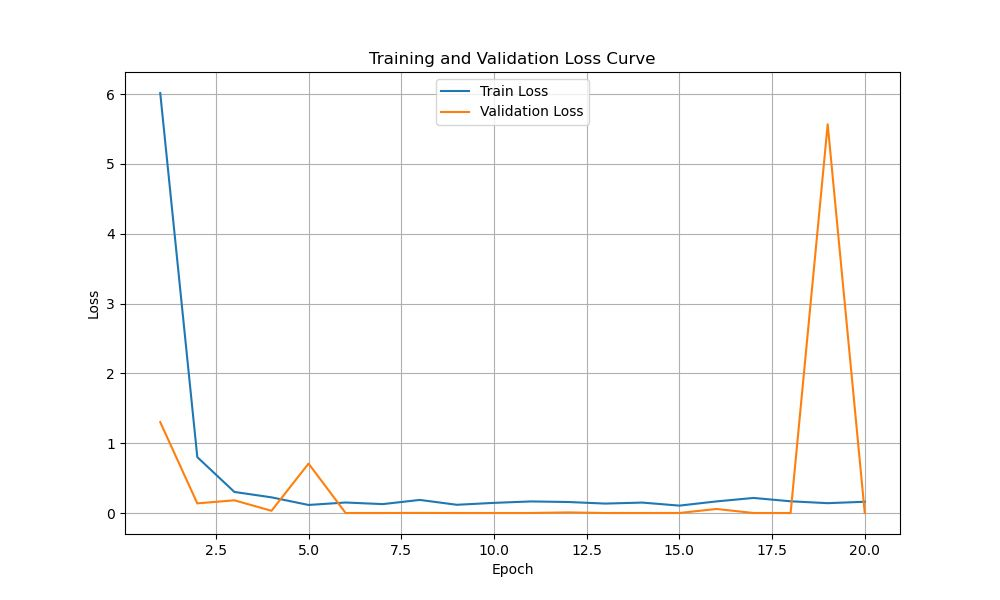
**Transfer Learning by KLD:**
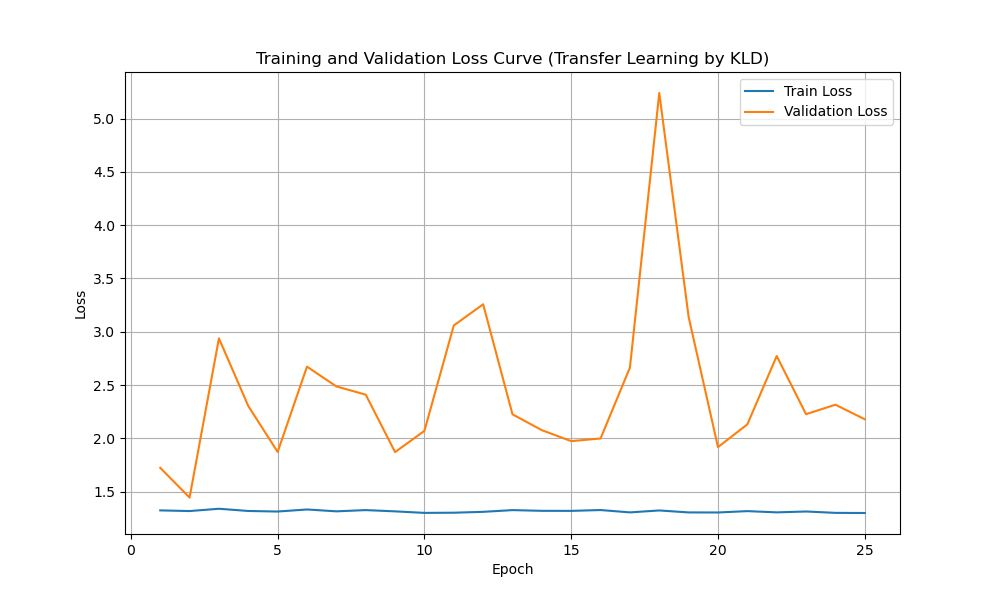
**Transfer Learning by Cosine Similarity:**
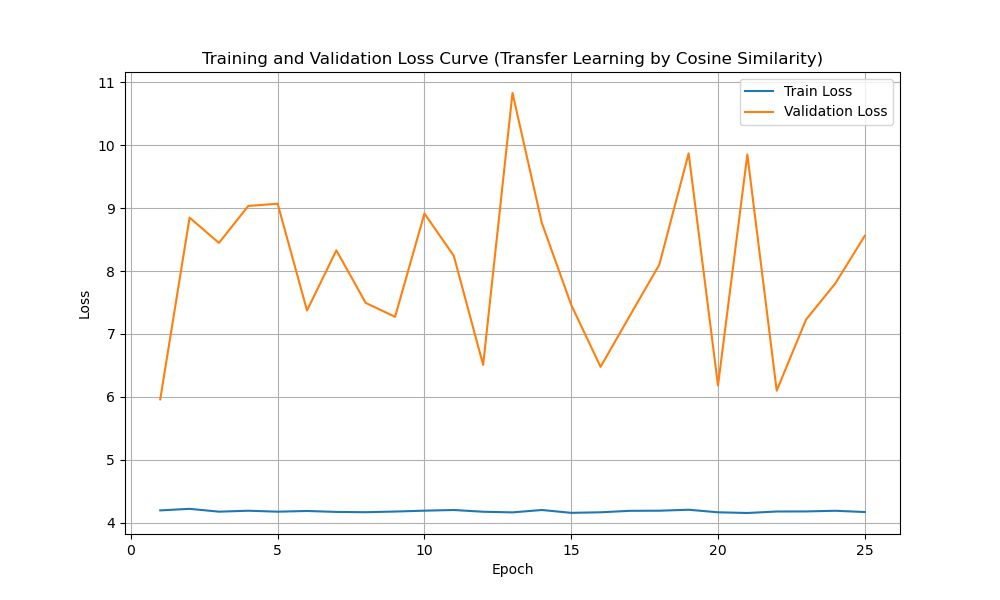
**Transfer Learning by L1 Cosine Similarity with Untrained Student:**
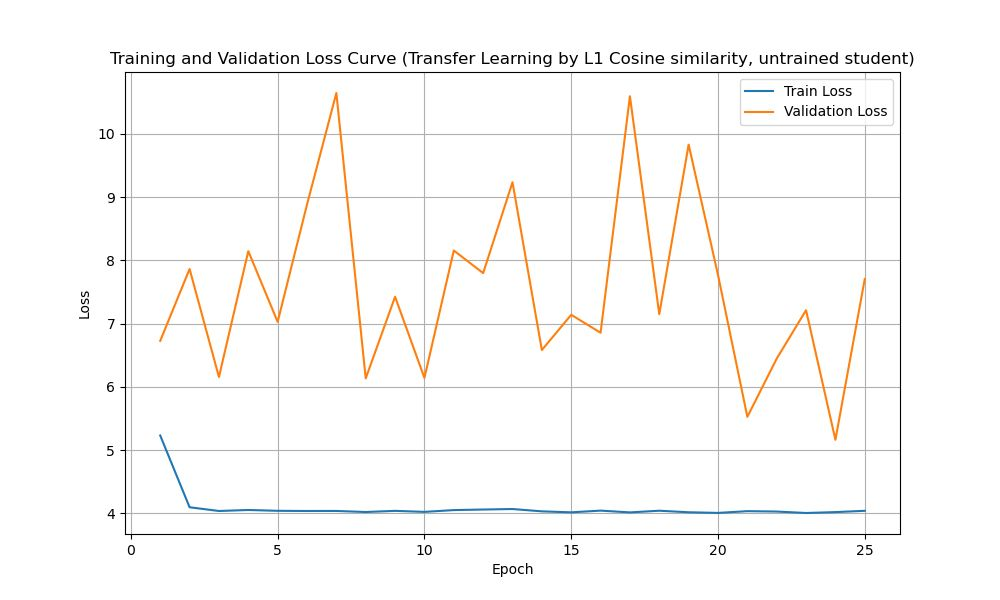
**Transfer Learning by L1 Regularization with Pretrained Student and Random Initialization:**
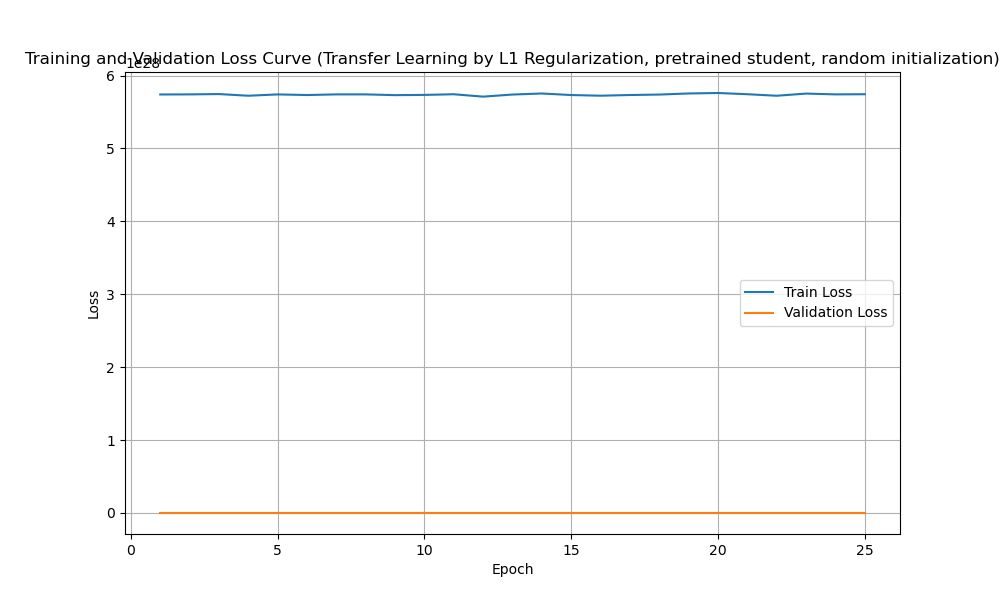
**Transfer Learning by L1 Regularization with Untrained Student and Spectral Initialization:**
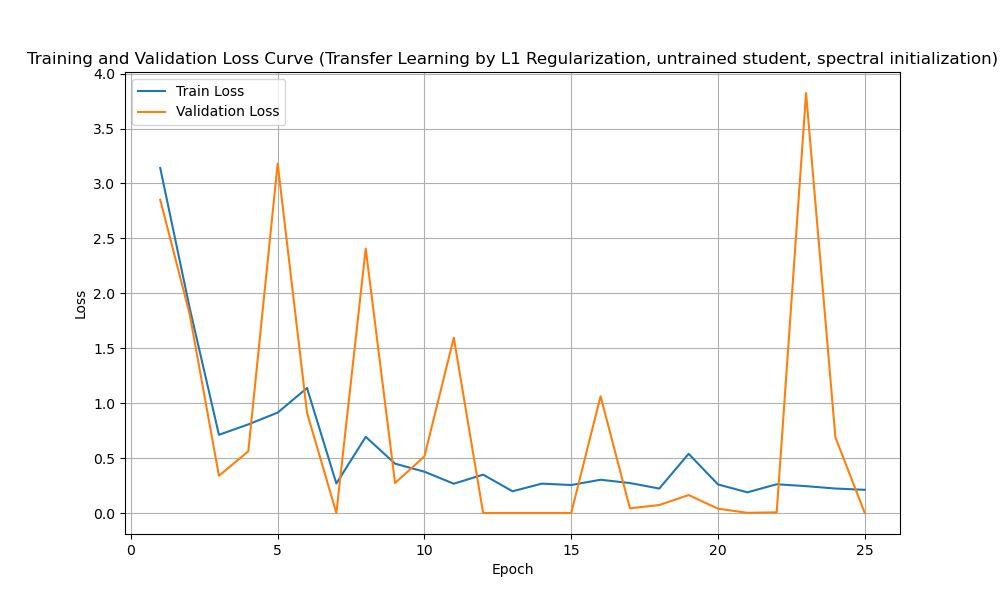

# Sample Testing Code

```python
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(_file_), "..")))

import torch
import matplotlib.pyplot as plt
import logging
from data.dataloader import EARSWHAMDataLoader
from training.losses.si_snr import SISNRLoss  # SI-SNR loss function
from models.conv_tasnet import build_conv_tasnet
import time
from tqdm import tqdm
from models.utils import load_model_with_adjusted_state_dict
from training.losses.si_snr import SISNRLoss
import numpy as np
import json

logging.basicConfig(level=logging.DEBUG, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(_name_)

data_loader = EARSWHAMDataLoader(
    base_dir="/dtu/blackhole/01/212577/datasets_final/EARS-WHAM16kHz",  
    seg_length=16000,  
    batch_size=1,
    num_workers=4  
)
logger.info('Data loader initialized')

model_dir = "/dtu/blackhole/01/212577/causal-speech-enhancement/models/saved-models/"

test_loader = data_loader.get_loader(split="test")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion_task = SISNRLoss()

### NON-CAUSAL MODEL WITH SPECTRAL INITALIZATION

spec_non_causal = build_conv_tasnet(causal=False, num_sources=2).to(device)
spec_non_causal_checkpoint = model_dir + "conv_tasnet_noncausal_spec_best_model.pth"
spec_non_causal.load_state_dict(torch.load(spec_non_causal_checkpoint, map_location=device)["model_state_dict"])
spec_non_causal.eval()  # Teacher remains in evaluation mode
for param in spec_non_causal.parameters():
    param.requires_grad = False
# Compile the non-causal model with spectral initalization
spec_non_causal = torch.compile(spec_non_causal, backend="inductor")
logger.info("Non-causal with spectral initalization model compiled with torch.compile")

### NON-CAUSAL MODEL

non_causal = build_conv_tasnet(causal=False, num_sources=2).to(device)
non_causal_checkpoint = model_dir + "conv_tasnet_noncausal_best_model.pth"
non_causal.load_state_dict(torch.load(non_causal_checkpoint, map_location=device)["model_state_dict"])
non_causal.eval()  # Teacher remains in evaluation mode
for param in non_causal.parameters():
    param.requires_grad = False
# Compile the non-causal model with spectral initalization
non_causal = torch.compile(non_causal, backend="inductor")
logger.info("Non-causal model compiled with torch.compile")


### CAUSAL MODEL

causal = build_conv_tasnet(causal=True, num_sources=2).to(device)
causal_checkpoint = model_dir + "conv_tasnet_causal_best_model.pth"
causal.load_state_dict(torch.load(causal_checkpoint, map_location=device)["model_state_dict"])
causal.eval()
for param in causal.parameters():
    param.requires_grad = False
causal = torch.compile(causal, backend="inductor")
logger.info("Pre-trained causal model loaded")

### KLD MODEL

kld = build_conv_tasnet(causal=True, num_sources=2).to(device)
kld_checkpoint = model_dir + "conv_tasnet_causal_transfer_kld_best_model.pth"
kld.load_state_dict(torch.load(kld_checkpoint, map_location=device)["model_state_dict"])
kld.eval()
for param in kld.parameters():
    param.requires_grad = False
kld = torch.compile(kld, backend="inductor")
logger.info("Pre-trained kld model loaded")

### L1 MODEL

l1 = build_conv_tasnet(causal=True, num_sources=2).to(device)
l1_checkpoint = model_dir + "conv_tasnet_causal_transfer_l1_best_model.pth"
l1 = load_model_with_adjusted_state_dict(l1, l1_checkpoint, device)
l1.eval()
for param in l1.parameters():
    param.requires_grad = False
l1 = torch.compile(l1, backend="inductor")
logger.info("Pre-trained kld model loaded")


### COSINE SIMILARITY MODEL

cosine = build_conv_tasnet(causal=True, num_sources=2).to(device)
cosine_checkpoint = model_dir + "conv_tasnet_causal_transfer_cosine_similarity_untrained_best_model.pth"
cosine = load_model_with_adjusted_state_dict(cosine, cosine_checkpoint, device)
cosine.eval()
for param in cosine.parameters():
    param.requires_grad = False
torch = torch.compile(cosine, backend="inductor")
logger.info("Pre-trained kld model loaded")


causal_losses = []
non_causal_losses = []
spec_non_causal_losses = []
kld_losses = []
l1_losses = []
cosine_losses = []


for clean_waveform, noisy_waveform in test_loader:
    clean_waveform = clean_waveform.to(device)
    noisy_waveform = noisy_waveform.to(device)
    # model outputs
    causal_output = causal(noisy_waveform)
    non_causal_output = non_causal(noisy_waveform)
    spec_non_causal_output = spec_non_causal(noisy_waveform)
    kld_output = kld(noisy_waveform)
    l1_output = l1(noisy_waveform)
    cosine_output = cosine(noisy_waveform)

    # Test losses
    # print(clean_waveform.shape, causal_output.shape)
    causal_loss = criterion_task(clean_waveform, causal_output[0])
    non_causal_loss = criterion_task(clean_waveform, non_causal_output[0])
    spec_non_causal_loss = criterion_task(clean_waveform, spec_non_causal_output[0])
    kld_loss = criterion_task(clean_waveform, kld_output[0])
    l1_loss = criterion_task(clean_waveform, l1_output[0])
    cosine_loss = criterion_task(clean_waveform, cosine_output[0])

    causal_losses.append(causal_loss.item())
    non_causal_losses.append(non_causal_loss.item())
    spec_non_causal_losses.append(spec_non_causal_loss.item())
    kld_losses.append(kld_loss.item())
    l1_losses.append(l1_loss.item())
    cosine_losses.append(cosine_loss.item())

loss_data = {
    "Causal": {
        "mean_loss": np.mean(causal_losses) if causal_losses else 0,
        "std_loss": np.std(causal_losses) if causal_losses else 0,
        "all_losses": causal_losses,
    },
    "Non-Causal": {
        "mean_loss": np.mean(non_causal_losses) if non_causal_losses else 0,
        "std_loss": np.std(non_causal_losses) if non_causal_losses else 0,
        "all_losses": non_causal_losses,
    },
    "Spec Non-Causal": {
        "mean_loss": np.mean(spec_non_causal_losses) if spec_non_causal_losses else 0,
        "std_loss": np.std(spec_non_causal_losses) if spec_non_causal_losses else 0,
        "all_losses": spec_non_causal_losses,
    },
    "KLD": {
        "mean_loss": np.mean(kld_losses) if kld_losses else 0,
        "std_loss": np.std(kld_losses) if kld_losses else 0,
        "all_losses": kld_losses,
    },
    "L1": {
        "mean_loss": np.mean(l1_losses) if l1_losses else 0,
        "std_loss": np.std(l1_losses) if l1_losses else 0,
        "all_losses": l1_losses,
    },
    "Cosine": {
        "mean_loss": np.mean(cosine_losses) if cosine_losses else 0,
        "std_loss": np.std(cosine_losses) if cosine_losses else 0,
        "all_losses": cosine_losses,
    },
}

# Save results to a JSON file
output_file = "test_results.json"
with open(output_file, "w") as f:
    json.dump(loss_data, f, indent=4)

# Plotting results
plt.figure(figsize=(12, 8))
plt.bar(models, losses, yerr=loss_std, capsize=5, color="skyblue")
plt.title("Model Loss Comparison (SI-SNR Loss)")
plt.xlabel("Models")
plt.ylabel("Mean SI-SNR Loss")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the figure
loss_comparison_path = os.path.join("/dtu/blackhole/01/212577/causal-speech-enhancement/experiments/", "model_loss_comparison.png")
plt.savefig(loss_comparison_path)
plt.show()

logger.info(f"Loss comparison plot saved at '{loss_comparison_path}'")import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(_file_), "..")))

import torch
import matplotlib.pyplot as plt
import logging
from data.dataloader import EARSWHAMDataLoader
from training.losses.si_snr import SISNRLoss  # SI-SNR loss function
from models.conv_tasnet import build_conv_tasnet
import time
from tqdm import tqdm
from models.utils import load_model_with_adjusted_state_dict
from training.losses.si_snr import SISNRLoss
import numpy as np
import json

logging.basicConfig(level=logging.DEBUG, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(_name_)

data_loader = EARSWHAMDataLoader(
    base_dir="/dtu/blackhole/01/212577/datasets_final/EARS-WHAM16kHz",  
    seg_length=16000,  
    batch_size=1,
    num_workers=4  
)
logger.info('Data loader initialized')

model_dir = "/dtu/blackhole/01/212577/causal-speech-enhancement/models/saved-models/"

test_loader = data_loader.get_loader(split="test")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion_task = SISNRLoss()

### NON-CAUSAL MODEL WITH SPECTRAL INITALIZATION

spec_non_causal = build_conv_tasnet(causal=False, num_sources=2).to(device)
spec_non_causal_checkpoint = model_dir + "conv_tasnet_noncausal_spec_best_model.pth"
spec_non_causal.load_state_dict(torch.load(spec_non_causal_checkpoint, map_location=device)["model_state_dict"])
spec_non_causal.eval()  # Teacher remains in evaluation mode
for param in spec_non_causal.parameters():
    param.requires_grad = False
# Compile the non-causal model with spectral initalization
spec_non_causal = torch.compile(spec_non_causal, backend="inductor")
logger.info("Non-causal with spectral initalization model compiled with torch.compile")

### NON-CAUSAL MODEL

non_causal = build_conv_tasnet(causal=False, num_sources=2).to(device)
non_causal_checkpoint = model_dir + "conv_tasnet_noncausal_best_model.pth"
non_causal.load_state_dict(torch.load(non_causal_checkpoint, map_location=device)["model_state_dict"])
non_causal.eval()  # Teacher remains in evaluation mode
for param in non_causal.parameters():
    param.requires_grad = False
# Compile the non-causal model with spectral initalization
non_causal = torch.compile(non_causal, backend="inductor")
logger.info("Non-causal model compiled with torch.compile")


### CAUSAL MODEL

causal = build_conv_tasnet(causal=True, num_sources=2).to(device)
causal_checkpoint = model_dir + "conv_tasnet_causal_best_model.pth"
causal.load_state_dict(torch.load(causal_checkpoint, map_location=device)["model_state_dict"])
causal.eval()
for param in causal.parameters():
    param.requires_grad = False
causal = torch.compile(causal, backend="inductor")
logger.info("Pre-trained causal model loaded")

### KLD MODEL

kld = build_conv_tasnet(causal=True, num_sources=2).to(device)
kld_checkpoint = model_dir + "conv_tasnet_causal_transfer_kld_best_model.pth"
kld.load_state_dict(torch.load(kld_checkpoint, map_location=device)["model_state_dict"])
kld.eval()
for param in kld.parameters():
    param.requires_grad = False
kld = torch.compile(kld, backend="inductor")
logger.info("Pre-trained kld model loaded")

### L1 MODEL

l1 = build_conv_tasnet(causal=True, num_sources=2).to(device)
l1_checkpoint = model_dir + "conv_tasnet_causal_transfer_l1_best_model.pth"
l1 = load_model_with_adjusted_state_dict(l1, l1_checkpoint, device)
l1.eval()
for param in l1.parameters():
    param.requires_grad = False
l1 = torch.compile(l1, backend="inductor")
logger.info("Pre-trained kld model loaded")


### COSINE SIMILARITY MODEL

cosine = build_conv_tasnet(causal=True, num_sources=2).to(device)
cosine_checkpoint = model_dir + "conv_tasnet_causal_transfer_cosine_similarity_untrained_best_model.pth"
cosine = load_model_with_adjusted_state_dict(cosine, cosine_checkpoint, device)
cosine.eval()
for param in cosine.parameters():
    param.requires_grad = False
torch = torch.compile(cosine, backend="inductor")
logger.info("Pre-trained kld model loaded")


causal_losses = []
non_causal_losses = []
spec_non_causal_losses = []
kld_losses = []
l1_losses = []
cosine_losses = []


for clean_waveform, noisy_waveform in test_loader:
    clean_waveform = clean_waveform.to(device)
    noisy_waveform = noisy_waveform.to(device)
    # model outputs
    causal_output = causal(noisy_waveform)
    non_causal_output = non_causal(noisy_waveform)
    spec_non_causal_output = spec_non_causal(noisy_waveform)
    kld_output = kld(noisy_waveform)
    l1_output = l1(noisy_waveform)
    cosine_output = cosine(noisy_waveform)

    # Test losses
    # print(clean_waveform.shape, causal_output.shape)
    causal_loss = criterion_task(clean_waveform, causal_output[0])
    non_causal_loss = criterion_task(clean_waveform, non_causal_output[0])
    spec_non_causal_loss = criterion_task(clean_waveform, spec_non_causal_output[0])
    kld_loss = criterion_task(clean_waveform, kld_output[0])
    l1_loss = criterion_task(clean_waveform, l1_output[0])
    cosine_loss = criterion_task(clean_waveform, cosine_output[0])

    causal_losses.append(causal_loss.item())
    non_causal_losses.append(non_causal_loss.item())
    spec_non_causal_losses.append(spec_non_causal_loss.item())
    kld_losses.append(kld_loss.item())
    l1_losses.append(l1_loss.item())
    cosine_losses.append(cosine_loss.item())

loss_data = {
    "Causal": {
        "mean_loss": np.mean(causal_losses) if causal_losses else 0,
        "std_loss": np.std(causal_losses) if causal_losses else 0,
        "all_losses": causal_losses,
    },
    "Non-Causal": {
        "mean_loss": np.mean(non_causal_losses) if non_causal_losses else 0,
        "std_loss": np.std(non_causal_losses) if non_causal_losses else 0,
        "all_losses": non_causal_losses,
    },
    "Spec Non-Causal": {
        "mean_loss": np.mean(spec_non_causal_losses) if spec_non_causal_losses else 0,
        "std_loss": np.std(spec_non_causal_losses) if spec_non_causal_losses else 0,
        "all_losses": spec_non_causal_losses,
    },
    "KLD": {
        "mean_loss": np.mean(kld_losses) if kld_losses else 0,
        "std_loss": np.std(kld_losses) if kld_losses else 0,
        "all_losses": kld_losses,
    },
    "L1": {
        "mean_loss": np.mean(l1_losses) if l1_losses else 0,
        "std_loss": np.std(l1_losses) if l1_losses else 0,
        "all_losses": l1_losses,
    },
    "Cosine": {
        "mean_loss": np.mean(cosine_losses) if cosine_losses else 0,
        "std_loss": np.std(cosine_losses) if cosine_losses else 0,
        "all_losses": cosine_losses,
    },
}

# Save results to a JSON file
output_file = "test_results.json"
with open(output_file, "w") as f:
    json.dump(loss_data, f, indent=4)

# Plotting results
plt.figure(figsize=(12, 8))
plt.bar(models, losses, yerr=loss_std, capsize=5, color="skyblue")
plt.title("Model Loss Comparison (SI-SNR Loss)")
plt.xlabel("Models")
plt.ylabel("Mean SI-SNR Loss")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the figure
loss_comparison_path = os.path.join("/dtu/blackhole/01/212577/causal-speech-enhancement/experiments/", "model_loss_comparison.png")
plt.savefig(loss_comparison_path)
plt.show()

logger.info(f"Loss comparison plot saved at '{loss_comparison_path}'")

```